<a href="https://colab.research.google.com/github/AraujoFernando/Portifolio/blob/master/Como_detectar_fraudes_em_cart%C3%B5es_de_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Detectação de Fraudes em Cartão de Crédito**
<p align=center>
<img src="http://mongeralaegon.blog.br/wp-content/uploads/2019/11/Fraudes-de-cart%C3%A3o-de-cr%C3%A9dito-destaque.png
" width="100%"></p>

Segundo *Carlos Sovegni*, Epecialista em Prevenção a Fraude na SAS América Latina, Estudos apontam que, no Brasil, empresas perdem cerca de 5% do seu lucro com fraudes. De um lado estão os cibercriminosos cada vez mais sofisticados e acompanhando a evolução tecnológica e do outro as instituições que são obrigadas a ampliar esforços na proteção dos dados de seus clientes e demais informações confidenciais.

Em 2019, cerca de **12,1 milhões** de pessoas foram vítimas de algum tipo de fraude apenas no Brasil,  de acordo com uma pesquisa da Confederação Nacional de Dirigentes Lojistas (CNDL), o prejuízo estimado equivale **1,8 bilhão**. Mais detalhes da a pesquisa [aqui](https://site.cndl.org.br/mais-de-12-milhoes-de-consumidores-sofreram-alguma-fraude-financeira-nos-ultimos-12-meses-aponta-pesquisa-cndlspc-brasil/).

As instintuiçoes tem investido cada vez mais em tecnologia na busca incessante de indentifcar de forma mais precisa uma transação fraudulenta, não só para evitar prejuízos mas também evitar o nosso constrangimento de ter o cartão bloqueado na hora de um compra por suspeita de fraude.

Diante destes números, neste projeto vamos abordar o problema de fraudes usando técnicas de machine learning para criar um modelo que possa identificar se uma transação é fraudulenta ou não.





In [48]:
!pip install scikit-plot -q

In [49]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

##Importação dos dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://media-exp1.licdn.com/dms/image/C4E12AQE4fCTjS6ZDaw/article-cover_image-shrink_720_1280/0?e=1600905600&v=beta&t=_cbkcHOy3Dq1T2Gp8GOVhef4Qj-gkKHbvt6hKt9mohM" width="40%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [2]:
# importando os dados

df = pd.read_csv("https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1")

##Análise Exploratória

Avaliando as cincos primeiras entradas do dataset podemos extrair algumas conclusões.

*   Estamos trabalhando com features anônimas por conta da tranformação PCA.
*   Com exceção das colunas `Time` e `Amount`, todas as colunas estão padronizadas.
*   A variável alvo está representada pela coluna `Class`, dividida em:
    *   **0** Transação Genuína
    *   **1** Transação Fraudulenta



In [3]:
# 5 primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Analisando o resumo estatístico utilazando o metodo `describe` é possível notar que as **Componente Princinpas** não apresentam discrepâncias, bem como a coluna `Time`.

Já a coluna `Amount` apresenta algumas particularidades:

*   Média - 88.34
*   Mediana - 22.00
*   Desvio padrão - 250.12
*   Valor maxímo - 25.691

No mais, a grande maioria das transações financeiras possuem pequenas quantias, o que é absolutamente compreensível em si tratando de compras com cartões de crédito.




In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


O conjunto de dados não apresentou valores ausentes ou que demandasse uma etapa de limpeza. Podemos confirmar utilizando a função abaixo, a qual retornará que o maior valor é zero

In [5]:
df.isnull().sum().max()

0

### Balanceamento do dataframe
Como informado anteriormente, nosso data frame contem **429 transações de fraude (1)**, que representa apenas **0,17% do total**  e mais **290.000 tranações genuínas (0)** . Com base nesses números já é possível afirmar que ele está desbalanceado. Graficamente temos:

Fraudes representam 0.1727% do dataset.



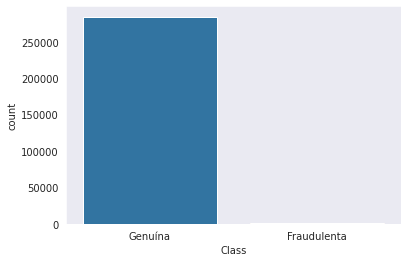

In [6]:
# plotando gráfico de barras para análisar o balanceamento
print(f'Fraudes representam {(df[df.Class == 1].shape[0] / df.shape[0] * 100):.4f}% do dataset.\n')

fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_xticklabels(['Genuína', 'Fraudulenta'])

plt.show()

A quantidade de transações fraudulentas são tão pequenas que o gráfico ficou deformado. Dada a prevalência da classe majoritária, nosso algoritmo provavelmente regredirá para uma previsão da classe majoritária. O algoritmo pode maximizar bastante sua precisão (uma das nossas métricas), prevendo arbitrariamente que a classe majoritária ocorre sempre. Este é um resultado trivial e fornece potência preditiva próxima de zero. 

A precisão preditiva, uma escolha popular para avaliar o desempenho de um classificador, pode não ser apropriada quando os dados estão desequilibrados e / ou os custos de erros diferentes variam acentuadamente.

Através da plotagem de histogramas podemos verificar o comportamento das duas classes na dimensão da variável `Time`.

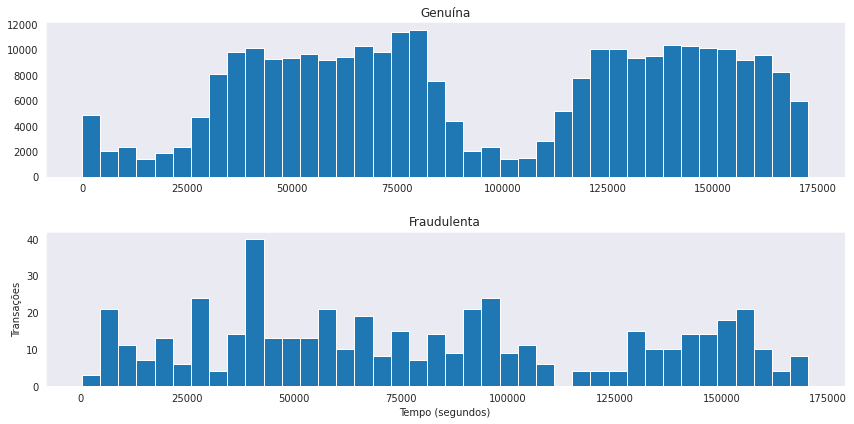

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
fig.subplots_adjust(hspace=500)

num_bins = 40
ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Genuína')

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title('Fraudulenta')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

[Text(0, 0, 'Genuína'), Text(0, 0, 'Fraudulenta')]

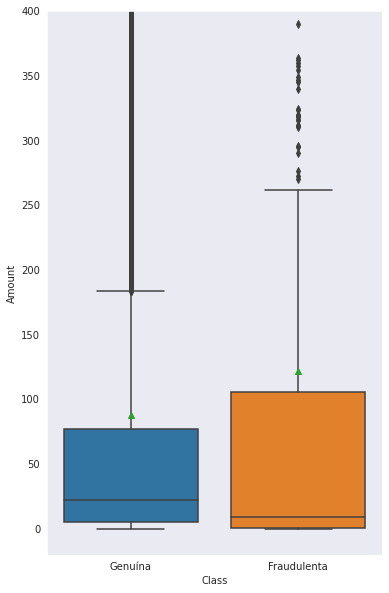

In [8]:
fig, ax = plt.subplots(figsize=(6, 10))

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
ax.set_ylim((-20, 400))
ax.set_xticklabels(['Genuína', 'Fraudulenta'])

In [29]:
df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

Recentemente, o Professor **Carlos Melo** do [Sigmoidal](www.https://sigmoidal.ai/) me apresentou o gráfico de densidade em um dos seus projetos. Como bem pontuado por ele, este gráfico é muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias.

De forma clara, o gráfico mostra onde existem concordâncias, vide vairiáveis **V15, V20, V25** e discrepâncias, variáveis **V3, V14, V17**.

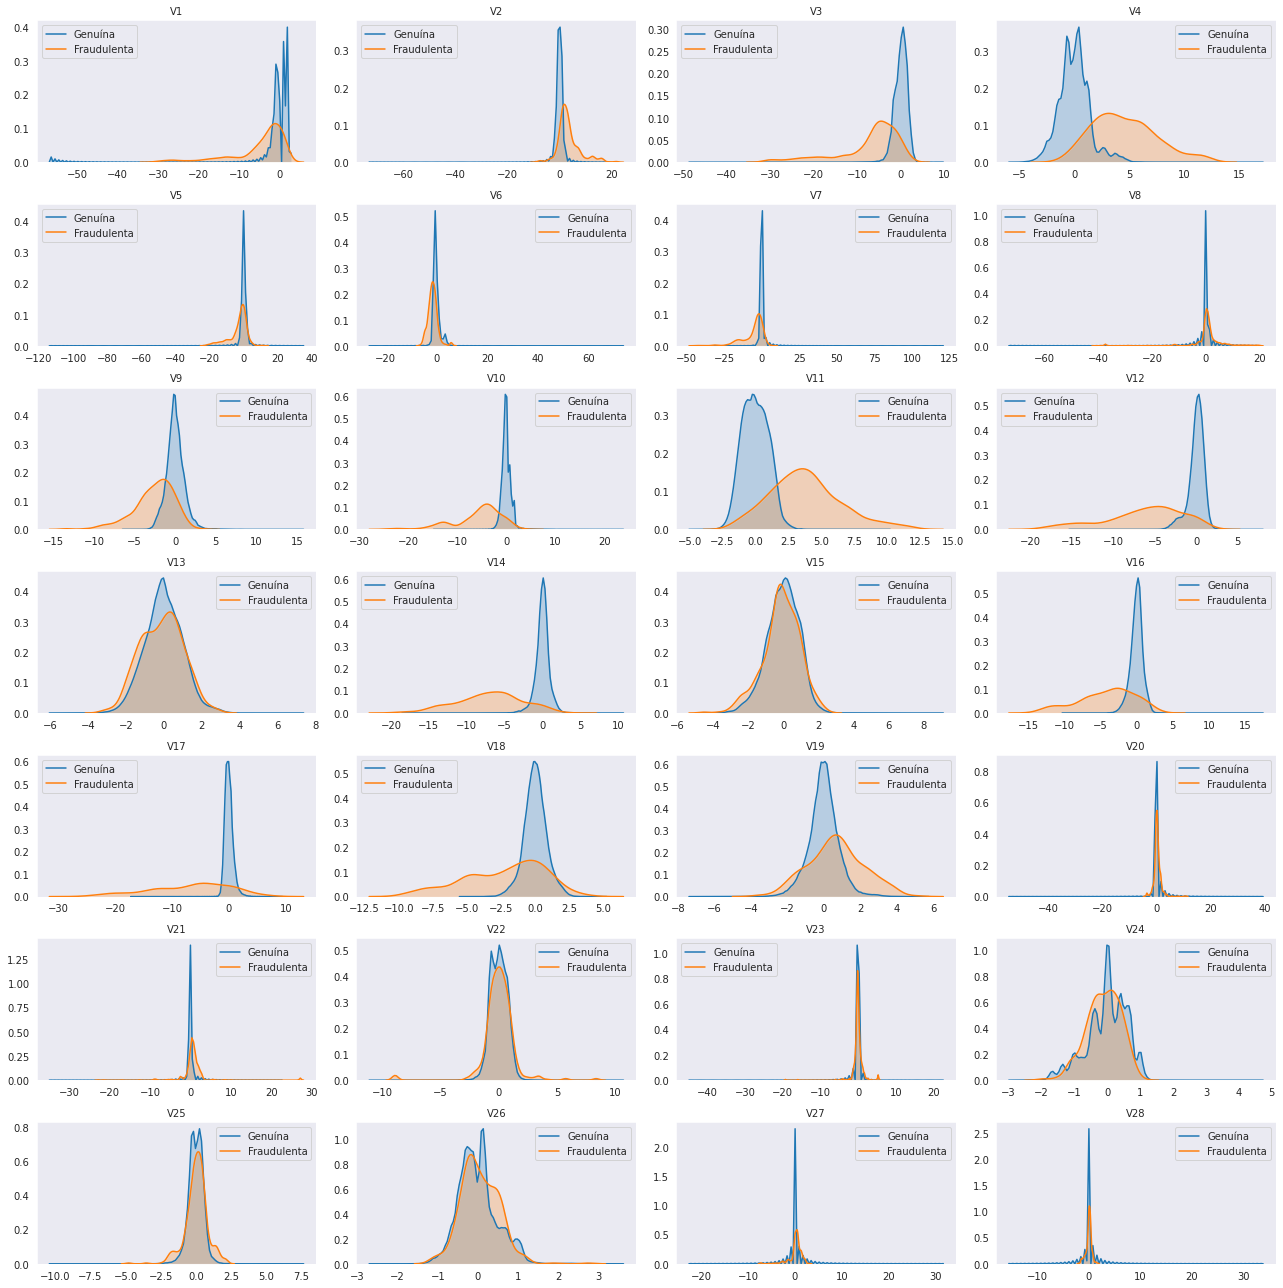

In [43]:
# gráfico de densidade
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Genuína", shade=True)
    sns.kdeplot(df_class_1[col], label="Fraudulenta", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

Após esse análise, o que temos:
*  Um dataset muito desbalanceado.
*  Não existem valores ausentes ou nulos.
*  O PCA é sensível a escala das variáveis, então presumisse que a variáveis originais foram padronizadas.
*  As variáveis `Time` e `Amount` não foram padronizadas.

##Preparando os dados

Para seguirmos com a implantação dos modelos de classificação, nesta fase iremos:
*  Padronizar as variáveis `Time` e `Amount`, que estão em escalas diferentes das demais.
*  Dividir os dados entre treino e teste.
*  Balancear os dados para evitarmos o **overfitting**, e uma baixa performace para a classe 1.

**Padronizar**  `Time` **e** `Amount`

Como visto no bloxplot a coluna `Amount` mostra a prensença de *Outliers*, para esse tarefa será utilizada a padronização por meio da classe `StandardScaler`.
Faremos uma copia do Dataset original afim de preservá-lo. As padronizações e posteriores aplicações, ocorrerão no dataset *df_clean* que é a cópia do dataset original *df*.

In [50]:
# padronizar as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


**Dividir o conjuto entre treinamento e teste**

Os dados devem ser divididos para que possamos ter parâmetros comparativos ao final de implantação do modelo.

Para garantir que os dados sejam divididos de forma proporcinal, será utilizado o parâmetro `stratify`.


In [51]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

**Balanceamento dos dados
Existem diversar formas pra realizar esta tarefa, uma delas é através da bibliteca `imblearn`, vamos utilizar a ***sampling***, uma abordagem simples mas, que vem sendo amplamente utilizada e com ótimos resultados. sub-dividida em:

*   **Over-sampling:** cria novas observações da classe minoritária a partir das informações contidas nos dados originais. Essa geração de novas entradas pode ser feita aleatoriamente com o auxílio de técnicas de clustering ou sinteticamente
*   **Under-sampling:** reduz o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

Optaremos aqui pela **Under-sampling**, afim de preservamos os dados minoritários.

1    369
0    369
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


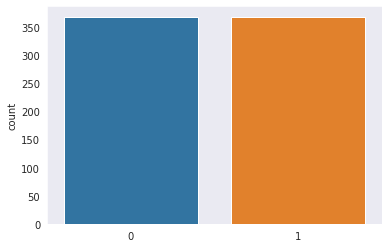

In [73]:
# usar técnica under-sampling
res = RandomUnderSampler()
X_res, y_res = res.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_res);

Com os dados devidamente balanceados, podemos verificar existência de correlação entre as variáves e ver quais estão mais diretamente ligadas com as outras.

Para efeitos de comparação, visualizaremos o antes e o depois do balanceamento.

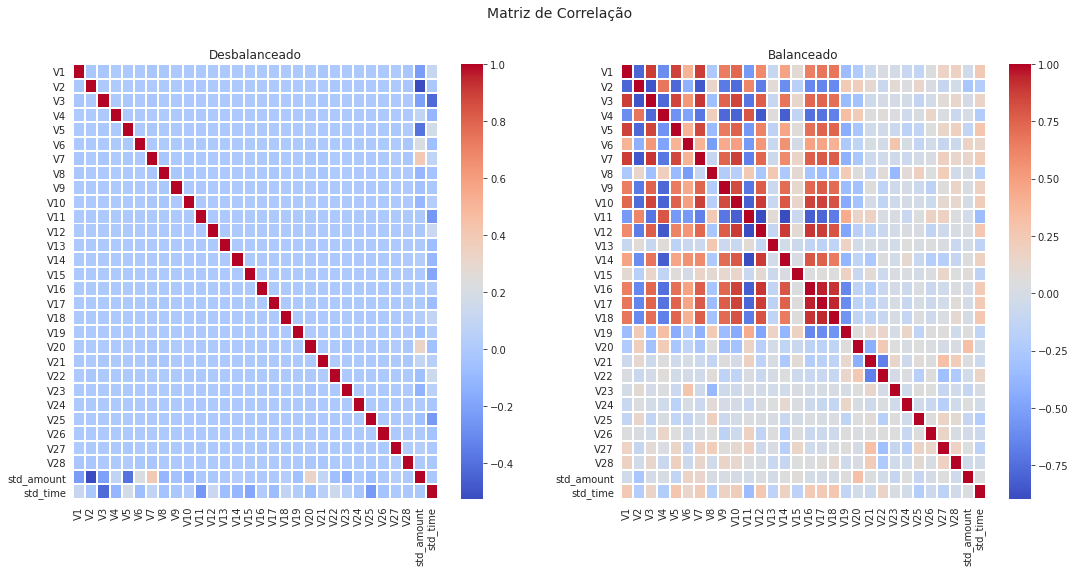

In [101]:
# plotar matriz de correlação
corr = X_train.corr()
corr_res = pd.DataFrame(X_res).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig.suptitle('Matriz de Correlação', fontsize=14)

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidth=1, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_res, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidth=1, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Balanceado');

##Criação dos Modelos
Com os dados balanceados, seguiremos com a criação dos modelos. Para essa abordagem apenas 2 modelos serão implantado, dentre os muitos disponíveis. São eles:
* Regressão Logística e
* Árvore de Decisão.

**Modelo 1 - Regressão Logística**

O modelo será instanciado e logo em seguida será treinado. Após o treinamento a previsão serão realizadas.

In [75]:
# instanciar e treinar o modelo
model = LogisticRegression()
model.fit(X_res, y_res)

# fazer previsões nos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


**Modelo 2 - Árvore de Decisão**
 
 Seguindo o roteiro do modelo anterior, partimos pra implantação do nosso segundo modelo.

In [76]:
# instanciando e treinando o modelo
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
model_dt.fit(X_res,y_res)

# fazer previsões
y_pred_dt = model_dt.predict(X_test)
y_proba_dt = model_dt.predict_proba(X_test)

##Avaliação de Desempenho

Com os modelos treinados as previsões realaizadas, é hora de avaliar os resultados e comparar o desempenho de ambos. É importante ressaltar o a principal função do modelo é detectar fraudes, logo, esse será o foco da avaliação.


**Relatórios de Classficação**

Vamos imprimir os relatório com as metrícas ultizadas para avaliar modelos de classificação.

In [78]:
# relatório de classificação
print(f'Modelo 1 - Regressão Logística: \n{classification_report(y_test, y_pred)}\n')
print(f'Modelo 2 - Árvore de Decisão: \n{classification_report(y_test, y_pred_dt)}\n')

Modelo 1 - Regressão Logística: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     71079
           1       0.04      0.93      0.08       123

    accuracy                           0.96     71202
   macro avg       0.52      0.95      0.53     71202
weighted avg       1.00      0.96      0.98     71202


Modelo 2 - Árvore de Decisão: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.06      0.89      0.11       123

    accuracy                           0.98     71202
   macro avg       0.53      0.93      0.55     71202
weighted avg       1.00      0.98      0.99     71202




Em números gerais, temos um melhor desempenho da Árvore de Decisão em relação a Regressão Logística, como por exemplo a acurácia que foi de **98%** e **96** respectivamente.

Caso nosso dateset estivesse balanceado, seria provavél que tivéssimos uma acurácia de mais de **99%**, que apesar de parecer bom, na verdade, tendiriamos a deixar cerca de **60%** das fraudes, como explicado pelo professor *Carlos Melo* neste artigo [aqui](http://sigmoidal.ai/como-lidar-com-dados-desbalanceados/).



Como mencionado a acurácia não é a melhor métrica para avaliação de desempenho. Utilizaremos a **AUC** que é uma derivada da curva **ROC**. A curva ROC mostra quão bom um modelo criado pode distinguir entre duas coisas. A AUC nada mais é que uma maneira de resumir a curva ROC em um único valor. Para saber mais sobre ROC-AUC veja este [artigo](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772).

In [81]:
# imprimindo AUC
print(f'AUC - Regressão Logística: {roc_auc_score(y_test, y_pred):.4f}')
print(f'AUC - Árvore de Decisão: {roc_auc_score(y_test, y_pred_dt):.4f}')

AUC - Regressão Linear: 0.9453
AUC - Árvore de Decisão: 0.9349


De fato, em relação a AUC, o modelo de Regresão Logística mostrou-se superior em pouco mais de **1%** em relação ao seu concorrente. Compravando mais uma vez que acurácia não pode ser a única metríca utilizada para escolha de um modelo.

**Matriz de Confusão**
Observaremos a matriz de confusão para ver a taxa de acertos para transações fraudulentas, o mesmo número pode ser visualizado pela coluna recall do Relatório de Classificação.

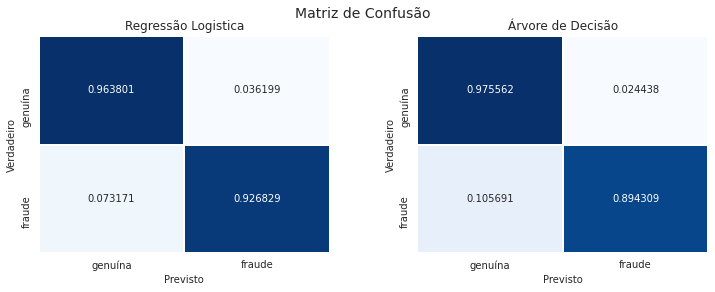

In [104]:
# plotanda matriz de confusão
fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
fig.subplots_adjust()
fig.suptitle('Matriz de Confusão', fontsize=14)
fig.subplots_adjust(wspace=.3)

sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True,
            linewidth=1, cmap='Blues', fmt='f', ax=ax1, cbar=False)
ax1.set_xlabel('Previsto')
ax1.set_xticklabels(['genuína', 'fraude'])
ax1.set_ylabel('Verdadeiro')
ax1.set_yticklabels(['genuína', 'fraude'])
ax1.set_title('Regressão Logistica')

sns.heatmap(confusion_matrix(y_test, y_pred_dt, normalize='true'), annot=True,
            linewidth=1, cmap='Blues', fmt='f', ax=ax2, cbar=False)
ax2.set_xlabel('Previsto')
ax2.set_xticklabels(['genuína', 'fraude'])
ax2.set_ylabel('Verdadeiro')
ax2.set_yticklabels(['genuína', 'fraude'])
ax2.set_title('Árvore de Decisão')
plt.show()

##Conclusão

O problema abordado, foi um trazido do mundo real. Os embora estivem bem tratados e sem valores ausente ou nulos, estavam desbalanceados, isso aliado a tranformação PCA, demandaram um tempo maior do que esperado.

Os resultados obtidos, podem ser considerados bons, mas não definitivos, há ainda muitos outros algoritimos que podem ser testados, e também a possibilidade de otimização dos parêmetros existentes nos modelos testados.